In [1]:
!ls movies_dataset/

genome-scores.csv  links.csv   ratings.csv  tags.csv
genome-tags.csv    movies.csv  README.txt


In [2]:
#!pip install sklearn
#!pip install numpy
#!pip install pandas
#!pip install pymongo

(1) Content-Based

- (a) Similarities between genres?
- (b) Similarities between actors? --PULL IN DATA--
- (c) Year of release
- (d) Similarities between plots/ summaries

Resources:
- https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4
- https://towardsdatascience.com/introduction-to-recommender-systems-1-971bd274f421
- https://www.geeksforgeeks.org/ml-content-based-recommender-system/

(2) Collaborative-Based

- (a) Ratings
- (b) Watched flag
- (c) Controls for which films to recommend ... do we want to exclude by number of votes? (Introduce some of the well performing movies - maybe see if there is a TF-IDF equivalent we can do?)
- (d) Rated weightings - others work

```
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)
```
where m = vote_counts.quantile(percentile) (Integer)

Currently using the average of vote scores -- can we use a distribution?
Incorporate the time / schedule of movies watched -- Can we catch we people are watching movies with too similar plot lines that they become boring?

Resource:
- https://realpython.com/build-recommendation-engine-collaborative-filtering/
- https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab
- https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101/notebook

We have two datasets. One from IMDB using the API web scraper and another which gives us actual user data. Collaborative and content based will be fed in from the second data set while the IMDB will enrich our dataset with:
(1) NLP techniques to extract information of note from reviews e.g. NER, Concepts, topics, moods.
(2) Sentiment - we also need to have an idea of how these match with ratings.

How to combine these? 
- We need to understand the effect these methods have on the watchers. Is this dependent on the individual? e.g. Some people are more likely to watch a film if a certain actor is involved (Content-based).
- Matrix? - Scores laid on eachother?
- Make each one then figure out the details.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
g_scores_df = pd.read_csv('../data/genome-scores.csv')
g_tags_df = pd.read_csv('../data/genome-tags.csv')
links_df = pd.read_csv('../data/links.csv')
ratings_df = pd.read_csv('../data/ratings.csv')
tags_df = pd.read_csv('../data/tags.csv')
movies_df = pd.read_csv('../data/movies.csv')

In [4]:
ratings_df.shape

(25000095, 4)

In [5]:
## Relevance in this context let's us know how relevant a tag is to the movie it is assigned. 
g_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [6]:
g_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [7]:
## Link ID's between 'themoviedatabase' and 'IMDB'
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [10]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
ratings_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [35]:
ratings_subset_df = ratings_df.sample(n=250000, weights='rating', random_state=1)

<AxesSubplot:ylabel='Frequency'>

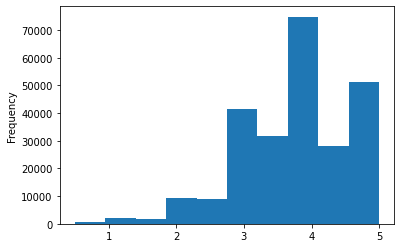

In [26]:
ratings_subset_df['rating'].plot(kind='hist')

In [27]:
ratings_subset_df.head()

,userId,movieId,rating,timestamp
12217086,79169,253,3.5,1375048204
17401053,112728,130576,4.0,1484147079
10537603,68338,97306,4.5,1395448628
4807399,31398,1485,5.0,975869633
22804699,148192,7419,5.0,1130805117


In [15]:
y = ratings_subset_df['rating']


In [16]:
X = ratings_subset_df.drop(columns=['rating'])
X.head()

,userId,movieId,timestamp
10435637,67708,2278,972621826
18013724,116679,2081,946661394
2847,13,81834,1297908469
7560292,49045,2997,1115322334
3664818,24234,365,914029928


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
from pymongo import MongoClient
from bson.objectid import ObjectId

In [32]:
client = MongoClient("localhost", 27017)
db = client['recsys-movies']

In [33]:
# collections
g_scores = db["g_scores"]
g_tags = db["g_tags"]
links = db["links"]
ratings = db["ratings"]
tags = db["tags"]
movies = db["movies"]

In [36]:
ratings_subset_df.reset_index(inplace=True)
data_dict = ratings_subset_df.to_dict("records")

In [38]:
results = ratings.insert_many(data_dict)

In [ ]:
for post in results.find()[:10]:
    print(post)

In [21]:
client.close()